✅ Model loaded from models\osteoporosis_resnet50.keras
Found 1947 files belonging to 3 classes.
Using 389 files for validation.
✅ Test dataset loaded with classes: ['Normal', 'Osteopenia', 'Osteoporosis']
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2856 - loss: 1.9768

📊 Test Loss: 1.7928
📊 Test Accuracy: 0.3111 (31.11%)
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
✅ Confusion Matrix saved: plots\confusion_matrix.png

🔍 Classification Report:
              precision    recall  f1-score   support

Osteoporosis     1.0000    0.3111    0.4745       389

   micro avg     1.0000    0.3111    0.4745       389
   macro avg     1.0000    0.3111    0.4745       389
weighted avg     1.0000    0.3111    0.4745       389

✅ Classification Report saved: plots\classification_report.txt


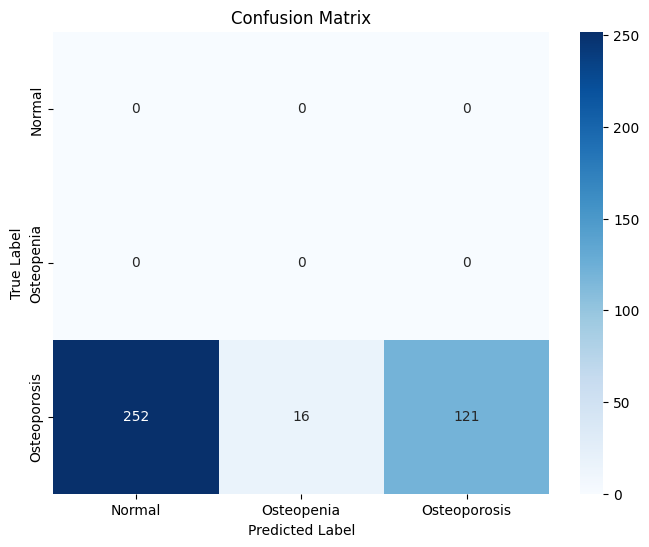

In [17]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

# --- Configuration Constants ---
DATASET_PATH = pathlib.Path(r'C:\Users\91947\Desktop\dap and iot\test\pro')  # <-- UPDATE THIS
MODEL_SAVE_PATH = pathlib.Path('./models')
PLOTS_SAVE_PATH = pathlib.Path('./plots')
MODEL_FILENAME = 'osteoporosis_resnet50.keras'

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2  # Must match the split used in training

# Ensure plots directory exists
PLOTS_SAVE_PATH.mkdir(parents=True, exist_ok=True)

# Class Names
CLASS_NAMES = ['Normal', 'Osteopenia', 'Osteoporosis']
NUM_CLASSES = len(CLASS_NAMES)

# --- 1. Validate Dataset Path ---
if not DATASET_PATH.exists():
    raise FileNotFoundError(f"ERROR: Dataset path does not exist: {DATASET_PATH}")

# --- 2. Load the Trained Model ---
model_path = MODEL_SAVE_PATH / MODEL_FILENAME
if not model_path.exists():
    raise FileNotFoundError(f"ERROR: Model file not found at {model_path}")

model = load_model(str(model_path))
print(f"✅ Model loaded from {model_path}")

# --- 3. Load Test Data ---
test_ds = image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling for evaluation
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset='validation'
)

print(f"✅ Test dataset loaded with classes: {test_ds.class_names}")

# --- 4. Preprocess Test Data ---
def preprocess_resnet(image, label):
    return preprocess_input(image), label

test_ds = test_ds.map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# --- 5. Evaluate Model ---
loss, accuracy = model.evaluate(test_ds)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"📊 Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# --- 6. Generate Predictions & True Labels ---
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

# --- 7. Generate Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

cm_filename = PLOTS_SAVE_PATH / 'confusion_matrix.png'
plt.savefig(str(cm_filename))
print(f"✅ Confusion Matrix saved: {cm_filename}")

# --- 8. Print Classification Report ---
print("\n🔍 Classification Report:")

# Find actual labels present in y_true
present_labels = np.unique(y_true)  # Get only present classes
present_class_names = [CLASS_NAMES[i] for i in present_labels]  # Filter class names

# Pass only present labels
report = classification_report(y_true, y_pred, labels=present_labels, target_names=present_class_names, digits=4)
print(report)

# Save report to a file
report_filename = PLOTS_SAVE_PATH / 'classification_report.txt'
with open(report_filename, 'w') as f:
    f.write(report)

print(f"✅ Classification Report saved: {report_filename}")
